#Solving QUBOs with Qiskit [Custom-built Circuit] QAOA

Date: December 4th, 2023

The notebook contains materials supporting the tutorial paper:
*Five Starter Problems: Solving QUBOs on Quantum Computers* by Arul Rhik Mazumder (arulm@andrew.cmu.edu) and Sridhar Tayur (stayur@cmu.edu).
It depends on various packages shown below.

### **Introduction**

Qiskit is an open-source quantum computing software development framework that allows researchers, developers, and enthusiasts to work with quantum computers and quantum algorithms. It is developed by IBM and provides tools and libraries for programming and running quantum circuits on real quantum hardware and simulators.

Qiskit is one of the best Quantum Circuit creation tools available online, but has a slight learning curve. It requires users to understand some the mathematics behind quantum computing which requires both linear algebra and probability theory.

Although this code is technically the hardest to set up and least refined, it provides the highest customizability to solving QUBOs to QAOA. Unlike Qiskit and OpenQAOA SDKs which require the user to choose from a list of cost Hamiltonians, mixer Hamiltonians, optimizers, etc., this vanilla implementation allows the user to custom-define all these aspects. While this implementation uses Qiskit features for the basic circuit creation process, it does not utilize any of the built-in circuits that Qiskit Optimization provides. Thus this implementation is best when trying to modify mixer Hamiltonians or experiment with optimizers like Ant Colony Swarm Optimization.

Further information can be found at the Qiskit Textbook:
https://qiskit.org/learn

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install -q qiskit==0.39.2
  !pip install -q qiskit-optimization==0.5.0
  !pip install -q qiskit[visualization]==0.39.2
  print("All Packages Installed!")

All Packages Installed!


In [ ]:
# Misc. Imports
import math
import time
from numpy import pi
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from scipy.optimize import minimize
from collections import defaultdict, Counter

# Qiskit Imports
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister, Aer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import circuit_drawer
from qiskit_optimization.translators import from_docplex_mp

### **Introduction - Custom Circuit Construction**
 Regardless of the problem addressed, the vanilla QAOA implementation requires a Cost Hamiltonian, Mixer Hamiltonian, and QAOA Circuit. Thus will implement this once below to reuse across many problems.

 The cost Hamiltonian encodes the objective function of the optimization problem you want to solve. It's typically a sum of terms, each associated with a specific constraint or cost in your optimization problem. The terms in H_C are represented as a weighted sum of Pauli-Z operators acting on one or more qubits. The weights represent the cost or penalty associated with violating the corresponding constraints.

In [ ]:
def cost_H(qc, gamma, quadratics, linears):
  for i in range(len(linears)):
    qc.rz(1/2*(linears[(0, i)]+sum(quadratics[(i, j)] for j in range(num_qubits)))*gamma, i)

  for (i, j) in quadratics.keys():
    if i!=j:
      qc.rzz((1/4)*quadratics[(i, j)]*gamma, i, j)

  qc.barrier()
  return qc

This Hamiltonian is chosen to be a simple operator that can prepare superposition states. It usually takes the form of a sum of single-qubit X operators or other Pauli-X operators acting on individual qubits. Its purpose is to create superposition in the quantum state.

In [ ]:
def mixer_H(qc, beta):
  for i in range(num_qubits):
    qc.rx(2*beta, i)
  qc.barrier()
  return qc

The Quantum Approximate Optimization Algorithm (QAOA) circuit is a parameterized quantum circuit used to find approximate solutions to combinatorial optimization problems. It comprises an initial superposition state, alternating sequences of mixer operators (e.g., Pauli-X gates) and cost Hamiltonian operators (encoding the problem's objective function), parameterized angles for these operators, and repeated steps to control circuit depth. By adjusting the parameters and measuring the quantum state at the end, QAOA aims to find optimal angles that minimize the expected value of the cost function, providing approximate solutions to a wide range of optimization problems.

In [ ]:
def circuit(gammas, betas, quadratics, linears):
  circuit = QuantumCircuit(num_qubits, num_qubits)
  assert(len(betas) == len(gammas))
  p = len(betas)

  for i in range(num_qubits):
    circuit.h(i)
  circuit.barrier()

  for i in range(p):
    circuit &= mixer_H(circuit, betas[i])
    circuit &= cost_H(circuit, gammas[i], quadratics, linears)

  circuit.measure(range(num_qubits), range(num_qubits))

  return circuit

In [ ]:
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]

### **Example 1 - Number Partitioning Problem**

Initializing an instance of the number partitioning problem


In [ ]:
test = [1, 5, 11, 5]
arr = test
n = len(arr)
c = sum(arr)

**Number Partitioning Models**

Given an array of $n$ integers $[a_{1}, a_{2}, a_{3} ... a_{n}]$, the corresponding Ising Hamiltonian is:

$$H=(\sum_{i=1}^{n}a_{i}s_{i})^2$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

Similarly the corresponding QUBO Model is:

$$Q=(\sum_{i=1}^{n}a_{i}-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$
or
$$Q=(c-2\sum_{i=1}^{n}a_{i}x_{i})^{2}$$

Where $c=\sum_{i=1}^{n}a_{i}$ and $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [ ]:
model = Model()
x = model.binary_var_list(n)
H = (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
model.minimize(H)
problem = from_docplex_mp(model)

In [ ]:
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)

In [ ]:
quadratics = qubo.objective.quadratic.coefficients
linears = qubo.objective.linear.coefficients
constant = qubo.objective.constant
num_qubits = qubo.get_num_vars()

Defining the NPP Expectation Value to be minimized during the circuit optimization.

In [ ]:
def npp_expectation(theta):
    backend = Aer.get_backend('qasm_simulator')
    middle = int(len(theta)/2)
    gammas = theta[:middle]
    betas = theta[middle:]
    pqc = circuit(gammas, betas, quadratics, linears)
    counts = execute(pqc, backend, shots=1000).result().get_counts()
    best_sol = max(counts, key=counts.get)

    return npp_obj(best_sol)

Define the NPP Objective function to calculate the expected value of a QAOA Circuit

In [ ]:
def npp_obj(str):
  sum_0 = 0
  sum_1 = 0
  for i in range(len(str)):
    if str[i] == '0':
      sum_0 += arr[i]
    else:
      sum_1 += arr[i]
  return abs(sum_0-sum_1)

Defining the Classical Optimizer for the QAOA circuit. In this case, it is Powell.

In [ ]:
# Initial guess
initial_guess = [0.5, 0.5, 0.5, 0.5]
start_time = time.time()
res = minimize(lambda x: npp_expectation(x), initial_guess, method='Powell')
end_time = time.time()
elapsed_time = end_time - start_time

Setting up the Qiskit Backend and executing the circuit.

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
middle = int(len(res.x)/2)
prime_gammas = res.x[:middle]
prime_betas = res.x[middle:]
NPPCircuit = circuit(prime_gammas, prime_betas, quadratics, linears)

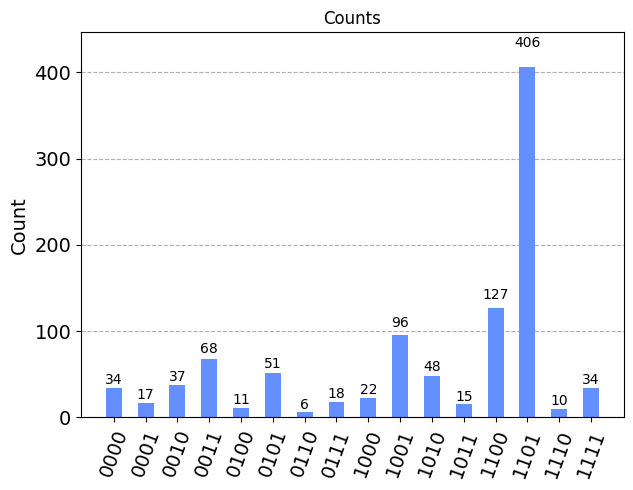

In [ ]:
job = execute(NPPCircuit, simulator, shots=1000)
result = job.result()
counts = result.get_counts()
most_common_results = dict(Counter(counts).most_common(40))
plot_histogram(most_common_results, title='Counts')

In [ ]:
def NPP_Sets(solution, print=None):
  P1 = []
  P2 = []
  for i in range(len(solution)):
      if solution[i] == '0':
          P1.append(arr[i])
      else:
          P2.append(arr[i])
  sum1 = sum(P1[i] for i in range(len(P1)))
  sum2 = sum(P2[i] for i in range(len(P2)))
  if print is not None:
    print(P1)
    print('Sum: ' + str(sum1))
    print(P2)
    print('Sum: ' + str(sum2))
  return abs(sum1 - sum2)

In [ ]:
k = math.floor(math.log10(2**(len(arr))))
solutions = find_most_common_solutions(counts, k)
print("Solutions: " + str(solutions))
sorted_solutions = sorted(solutions, key=npp_obj)

Solutions: ['1101']


In [ ]:
print("Number of Sampled Solutions: " + str(k))
print("Optimization Time: " + str(elapsed_time))
NPP_Sets(sorted_solutions[0], print)

Number of Sampled Solutions: 1
Optimization Time: 40.55613374710083
[11]
Sum: 11
[1, 5, 5]
Sum: 11


0

### **Example 2 - Max-Cut Problem**

In [ ]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")

Initializing a Max-Cut Instance.

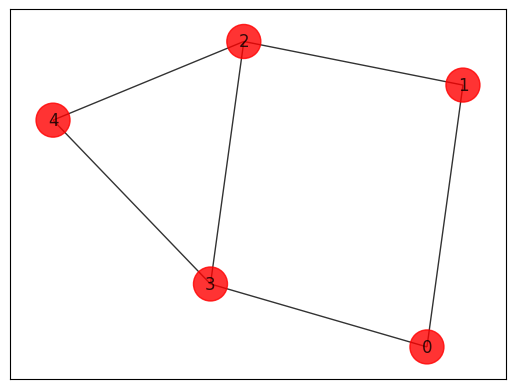

In [ ]:
# Generating a graph of 4 nodes

n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 1, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Max-Cut Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=\sum_{(i, j) \in E}\frac{1-s_{i}s_{j}}{2}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable.

The corresponding QUBO Model is:

$$Q=\sum_{(i, j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

In [ ]:
model = Model()
x = model.binary_var_list(n)
H = sum(2*x[e[0]]*x[e[1]] - x[e[0]] - x[e[1]] for e in edges)
model.minimize(H)
problem = from_docplex_mp(model)

In [ ]:
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo)

minimize 2*x0*x1 + 2*x0*x3 + 2*x1*x2 + 2*x2*x3 + 2*x2*x4 + 2*x3*x4 - 2*x0 - 2*x1 - 3*x2 - 3*x3 - 2*x4 (5 variables, 0 constraints, 'docplex_model47')


In [ ]:
quadratics = qubo.objective.quadratic.coefficients
linears = qubo.objective.linear.coefficients
constant = qubo.objective.constant
num_qubits = qubo.get_num_vars()

Defining the Max-Cut objective function that will be using the calculate the expected value of each bitstring.

In [ ]:
def maxcut_obj(str):
  cut_size = 0
  for u, v in G.edges():
      if str[u] != str[v]:
          cut_size -= 1
  return cut_size

Calculating the expected value of a Max Cut QAOA Circuit.

In [ ]:
def maxcut_expectation(theta):
    backend = Aer.get_backend('qasm_simulator')
    middle = int(len(theta)/2)
    gammas = theta[:middle]
    betas = theta[middle:]
    pqc = circuit(gammas, betas, quadratics, linears)
    counts = execute(pqc, backend, shots=1000).result().get_counts()
    best_sol = max(counts, key=counts.get)

    return maxcut_obj(best_sol)

Defining the classical optimizer for the QAOA circuit. In this case it is Nelder-Mead.

In [ ]:
# Initial guess
initial_guess = [0.5, 0.75, 0.5, 0.5]
start_time = time.time()
res = minimize(lambda x: maxcut_expectation(x), initial_guess, method='Nelder-Mead')
end_time = time.time()
elapsed_time = end_time - start_time

Setting up the Qiskit Backend and executing the circuit.

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
middle = int(len(res.x)/2)
prime_gammas = res.x[:middle]
prime_betas = res.x[middle:]
MAXCUTCircuit = circuit(prime_gammas, prime_betas, quadratics, linears)

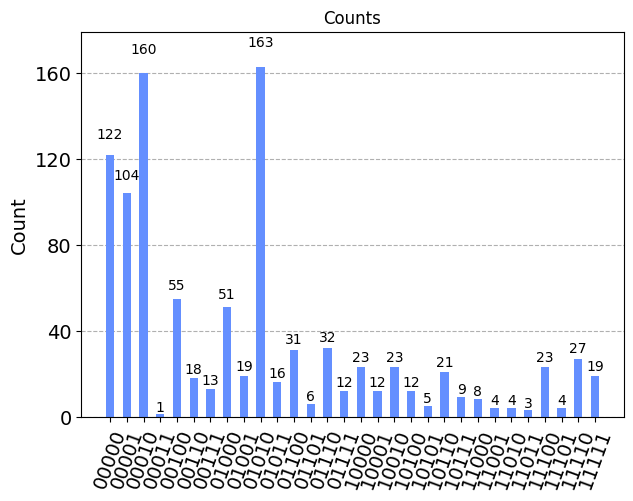

In [ ]:
job = execute(MAXCUTCircuit, simulator, shots=1000)
result = job.result()
counts = result.get_counts()
most_common_results = dict(Counter(counts).most_common(40))
plot_histogram(most_common_results, title='Counts')

In [ ]:
k = math.floor(math.log10(2**(n)))
solutions = find_most_common_solutions(counts, k)
print("Solutions: " + str(solutions))
sorted_solutions = sorted(solutions, key=maxcut_obj)

Solutions: ['01010']


In [ ]:
maxcut_solution = sorted_solutions[0]
print(maxcut_solution)

01010


Optimization Time: 18.346456289291382


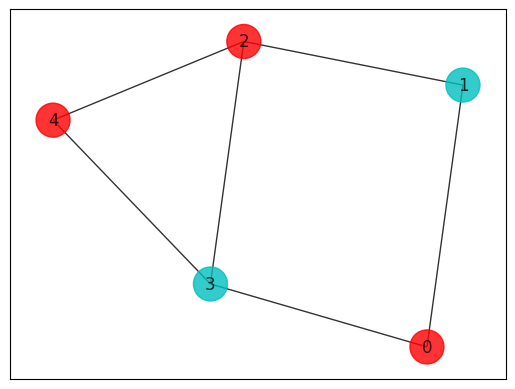

In [ ]:
colors = ["r" if maxcut_solution[i] == "0" else "c" for i in range(len(maxcut_solution))]
print("Optimization Time: " + str(elapsed_time))
draw_graph(G, colors, pos)

### **Example 3 - Minimum Vertex Cover**

Initializing a minimum vertex cover instance.

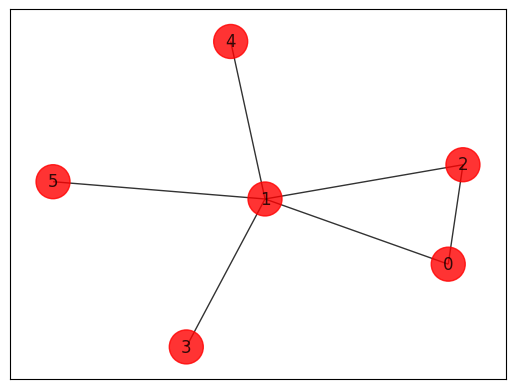

In [ ]:
# Generating a graph of 4 nodes

n = 6  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edges = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0)]
G.add_weighted_edges_from(edges)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

**Minimum Vertex Cover Models**

Given an undirected unweighted Graph $G$ with vertex set $V$ with vertices $i$ and edge set $E$ with edges $(i, j)$ the corresponding Ising Hamiltonian is:

$$H=P\sum_{(i, j) \in E}(1-s_{i})(1-s_{j}) + \sum_{i \in V}s_{i}$$

Where $s_{i} \in \{-1,1\}$ is the Ising spin variable and $P$ is the penalty coefficient.

The corresponding QUBO Model is:

$$Q=\sum_{i \in V}x_{i} + P(\sum_{(i, j) \in E}(1-x_{i}-x_{j}+x_{i}x_{j}))$$

Where $x_{i} \in \{0, 1\}$ is a binary quadratic variable.

Note in the example $P$ was chosen through trial-and-error although there exists rigorous mathematical processes

In [ ]:
model = Model()
x = model.binary_var_list(n)
P = 0.5
H = sum(x[i] for i in range(n)) + P*sum(1 - x[e[0]] - x[e[1]] + x[e[0]]*x[e[1]] for e in edges)
model.minimize(H)
problem = from_docplex_mp(model)

In [ ]:
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo)

minimize 0.5*x0*x1 + 0.5*x0*x2 + 0.5*x1*x2 + 0.5*x1*x3 + 0.5*x1*x4 + 0.5*x1*x5 - 1.5*x1 + 0.5*x3 + 0.5*x4 + 0.5*x5 + 3 (6 variables, 0 constraints, 'docplex_model61')


In [ ]:
quadratics = qubo.objective.quadratic.coefficients
linears = qubo.objective.linear.coefficients
constant = qubo.objective.constant
num_qubits = qubo.get_num_vars()

Defining the Minimum Vertex Cover Objective Function to calculate the expected value of a bitstring.

In [ ]:
def mvc_obj(str, P):
    marked_edges = 0
    for u, v in G.edges():
      if str[u] == "1" or str[v] == "1":
        marked_edges -= 1
    num_marked = 0
    for i in range(len(str)):
      if str[i] == "1":
        num_marked += 1
    return P*marked_edges+num_marked

Calculating the expected value of a Minimum Vertex Cover QAOA Circuit.

In [ ]:
def mvc_expectation(theta, P):
    backend = Aer.get_backend('qasm_simulator')
    middle = int(len(theta)/2)
    gammas = theta[:middle]
    betas = theta[middle:]
    pqc = circuit(gammas, betas, quadratics, linears)
    counts = execute(pqc, backend, shots=1000).result().get_counts()
    best_sol = max(counts, key=counts.get)

    return mvc_obj(best_sol, P)

Defining the classical optimizer for the QAOA circuit. In this case it is BFGS.

In [ ]:
# Initial guess
initial_guess = [np.pi/6, np.pi/6, np.pi/6, np.pi/6]
start_time = time.time()
res = minimize(lambda x: mvc_expectation(x, P), initial_guess, method='BFGS')
end_time = time.time()
elapsed_time = end_time - start_time

Setting up the Qiskit Backend and executing the circuit.

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
middle = int(len(res.x)/2)
prime_gammas = res.x[:middle]
prime_betas = res.x[middle:]
MVCCircuit = circuit(prime_gammas, prime_betas, quadratics, linears)

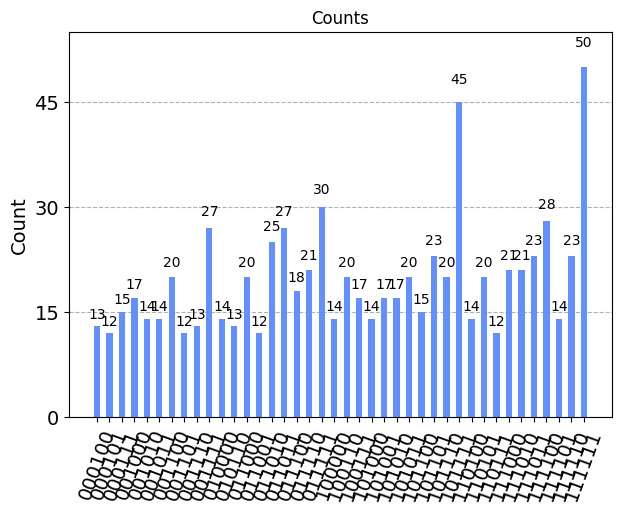

In [ ]:
job = execute(MVCCircuit, simulator, shots=1000)
result = job.result()
counts = result.get_counts()
most_common_results = dict(Counter(counts).most_common(40))
plot_histogram(most_common_results, title='Counts')

In [ ]:
k = 3 #math.floor(math.log10(2**(n)))
solutions = find_most_common_solutions(counts, k)
print("Solutions: " + str(solutions))
sorted_solutions = sorted(solutions, key=lambda solution: mvc_obj(solution, P))

Solutions: ['111111', '101111', '011111']


In [ ]:
mvc_solution = sorted_solutions[0]
print(mvc_solution)

101111


Optimization Time: 15.193472385406494


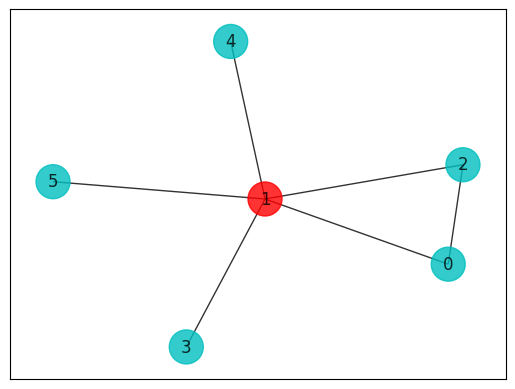

In [ ]:
colors = ["r" if mvc_solution[i] == "0" else "c" for i in range(len(mvc_solution))]
print("Optimization Time: " + str(elapsed_time))
draw_graph(G, colors, pos)